In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import datetime
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing

In [2]:
# set table names
table_names = ['groups', 'venues', 'events']

# create tables form data
df_dict = {table_names[i]: pd.read_csv('data/' + table_names[i] + '.csv', encoding='ISO-8859-1') for i in range(len(table_names))}


In [3]:
#examine contents of each table
for key in df_dict.keys():
    print(key + '\n', df_dict[key].head(), '\n\n\n')

groups
    group_id  category_id          category.name     category.shortname  \
0      6388           14       health/wellbeing       health-wellbeing   
1      6510            4  community/environment  community-environment   
2      8458           26           pets/animals           pets-animals   
3      8940           29         sci-fi/fantasy         sci-fi-fantasy   
4     10104           26           pets/animals           pets-animals   

   city_id      city country              created  \
0    10001  New York      US  2002-11-21 16:50:46   
1    10001  New York      US  2003-05-20 14:48:54   
2    10001  New York      US  2004-03-27 09:55:41   
3    10001  New York      US  2002-11-16 04:49:16   
4    10001  New York      US  2003-10-22 21:39:49   

                                         description  \
0  Those who practice or hold a strong interest i...   
1  The New York Alternative Energy Meetupis for t...   
2                                          not_found   
3  W

In [4]:
#creating features from columns in events, groups and venues tables
df_main = df_dict['events'].merge(df_dict['venues'].iloc[:, [0, 9,10,13]], on='venue_id', how='left')
groups = df_dict['groups'].iloc[:, [0,1, 2, 3 ,4, 8, 19, 29, 34]]
groups.rename(columns={'description': 'group_description', 'rating': 'organizer_picture_rating', 
                       'visibility': 'group_visibility'}, inplace=True)
df_main = df_main.merge(groups, on='group_id', how='left')
df_main.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,event_id,created,description,duration,event_url,fee.accepts,fee.amount,fee.currency,fee.description,fee.label,...,rating_count,normalised_rating,category_id,category.name,category.shortname,city_id,group_description,members,organizer_picture_rating,group_visibility
0,153868222,2013-12-03 21:24:29,Solve the murder case while eating a 3 course ...,20700,https://www.meetup.com/SanFranciscoStartupFun/...,others,0.0,not_found,per person,Price,...,1.0,1.50,2,career/business,career-business,94101,There are too many Startups Events in the Bay ...,917,4.67,public
1,184167702,2014-05-20 18:52:00,NOTE: This event is EVERY FRIDAY!! Signup is a...,77400,https://www.meetup.com/hr-and-tech-sf/events/1...,others,0.0,not_found,per person,Price,...,2.0,3.33,2,career/business,career-business,94101,HR and Tech SF is a new recurring event bringi...,1977,4.60,public
2,215200502,2014-10-23 16:18:44,We'll be heading out with a group of travelers...,37800,https://www.meetup.com/hr-and-tech-sf/events/2...,others,0.0,not_found,per person,Price,...,0.0,0.00,2,career/business,career-business,94101,HR and Tech SF is a new recurring event bringi...,1977,4.60,public
3,220826782,2015-02-28 19:27:32,NOTE: This event is EVERY FRIDAY!! Signup is a...,113400,https://www.meetup.com/SanFranciscoStartupFun/...,others,0.0,not_found,per person,Price,...,26.0,3.81,2,career/business,career-business,94101,There are too many Startups Events in the Bay ...,917,4.67,public
4,227948102,2016-01-08 21:35:40,"Aussie Aussie Aussie, Oi Oi Oi! Join us for th...",36000,https://www.meetup.com/hr-and-tech-sf/events/2...,others,0.0,not_found,per person,Price,...,1.0,2.00,2,career/business,career-business,94101,HR and Tech SF is a new recurring event bringi...,1977,4.60,public


In [5]:
#creating features from columns in events and venues tables
df_master1 = df_dict['events'].merge(df_dict['venues'].iloc[:, [0, 9,10,13]], on='venue_id', how='left')
groups = df_dict['groups'].iloc[:, [0,1, 2, 3 ,4, 8, 19, 29, 34]]
groups.rename(columns={'description': 'group_description', 'rating': 'organizer_picture_rating', 'visibility': 'group_visibility'}, inplace=True)
df_final = df_master1.merge(groups, on='group_id', how='left')

to_drop = ['venue.zip', 'event_status', 'headcount', 'why','fee.currency', 'fee.description', 
           'fee.label', 'photo_url', 'event_url', 'group.urlname']
df_final.drop(to_drop, axis=1, inplace=True)

#change paragraph data to length
par_cols = ['description', 'group_description', 'group.who']
for col in par_cols:
    df_final[col] = df_final[col].str.len()

#change phone feature to yes or no
phone = df_final['venue.phone']
phone = phone != -1
df_final['venue.phone'] = phone

how = df_final[df_final['how_to_find_us'] != 'not_found']['how_to_find_us']
how = how.str.len()

df_final['how_to_find_us'] = how
df_final['how_to_find_us'].fillna(1.0, inplace=True)

df_final['rsvp_limit'] = df_final['rsvp_limit'].apply(lambda x: 1 if x  > -1 else 0)

#drop additional excess fields
drop_more = ['category_id', 'category.shortname', 'maybe_rsvp_count', 'created', 'group.created',
            'event_id', 'group.group_lat', 'group.group_lon', 'updated', 'utc_offset',
            'venue_id', 'venue.repinned','city_id', 'rsvp_limit', 'venue.localized_country_name',
             'venue.country', 'group.join_mode', 'visibility', 'venue.address_1', 'venue.address_2']


df_final = df_final.drop(drop_more, axis=1)


# translate datetime values into useful features
event_time = df_final['event_time'].str.split(' ')
event_time = np.array(list(event_time))

df_final['event_date'] = pd.Series(event_time[:, 0])
df_final['event_time_of_the_day'] = pd.Series(event_time[:, 1])

days = pd.to_datetime(df_final['event_date']).dt.dayofweek
days = pd.Series(days)

months = pd.to_datetime(df_final['event_date']).dt.month
months = pd.Series(months)

df_final = df_final.drop('event_date', axis=1)

df_final['day_of_the_week'] = days
df_final['month'] = months

df_final['event_hour'] = pd.to_datetime(df_final['event_time']).dt.hour + pd.to_datetime(df_final['event_time']).dt.minute / 60

theta = 2 * math.pi * df_final['event_hour'] / 24
df_final['sin_hour'] = pd.Series(np.sin(theta))
df_final['cos_hour'] = pd.Series(np.cos(theta))

df_final = df_final.drop('event_hour', axis=1)



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [6]:
# clean data
df_final['venue.city'].value_counts()

Chicago                    2305
New York                   1773
San Francisco              1619
san francisco                50
SAN FRANCISCO                48
New York,                     5
New York City                 4
New York,NY                   1
San Francisco, CA 94103       1
Chicago, IL                   1
Name: venue.city, dtype: int64

In [7]:
#clean cities
df_final['venue.city'].loc[df_final['venue.city'] == 'san francisco'] = 'San Francisco'
df_final['venue.city'].loc[df_final['venue.city'] == 'SAN FRANCISCO'] = 'San Francisco'
df_final['venue.city'].loc[df_final['venue.city'] == 'San Francisco, CA 94103'] = 'San Francisco'

df_final['venue.city'].loc[df_final['venue.city'] == 'New York City'] = 'New York'
df_final['venue.city'].loc[df_final['venue.city'] == 'New York,'] = 'New York'
df_final['venue.city'].loc[df_final['venue.city'] == 'New York,NY'] = 'New York'

df_final['venue.city'].loc[df_final['venue.city'] == 'Chicago, IL'] = 'Chicago'

df_final['venue.city'].value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Chicago          2306
New York         1783
San Francisco    1718
Name: venue.city, dtype: int64

In [8]:
# clean states
df_final['venue.state'].loc[df_final['venue.state'] == 'Il'] = 'IL'
df_final['venue.state'].loc[df_final['venue.state'] == 'Ne'] = 'NY'
df_final['venue.state'].value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


IL           2108
NY           1648
CA           1556
not_found     495
Name: venue.state, dtype: int64

In [9]:
df_final.columns

Index(['description', 'duration', 'fee.accepts', 'fee.amount', 'fee.required',
       'group_id', 'group.name', 'group.who', 'how_to_find_us', 'event_name',
       'rating.average', 'rating.count', 'event_time', 'venue.city',
       'venue.lat', 'venue.lon', 'venue.name', 'venue.phone', 'venue.state',
       'waitlist_count', 'yes_rsvp_count', 'rating', 'rating_count',
       'normalised_rating', 'category.name', 'group_description', 'members',
       'organizer_picture_rating', 'group_visibility', 'event_time_of_the_day',
       'day_of_the_week', 'month', 'sin_hour', 'cos_hour'],
      dtype='object')

In [10]:
# label encode non-numeric data
df_final2 = df_final.copy()
categorical_columns = df_final2.select_dtypes(include=['object']).columns
le = preprocessing.LabelEncoder()
for col in categorical_columns:
    df_final2[col] = le.fit_transform(df_final2[col].astype(str))

df_final2.head(5)

,description,duration,fee.accepts,fee.amount,fee.required,group_id,group.name,group.who,how_to_find_us,event_name,...,category.name,group_description,members,organizer_picture_rating,group_visibility,event_time_of_the_day,day_of_the_week,month,sin_hour,cos_hour
0,827.0,20700,1,0.0,0,5817262,257,7,143.0,356,...,1,491,917,4.67,0,10,0,10,0.608761,0.793353
1,2006.0,77400,1,0.0,0,1627081,128,7,1.0,211,...,1,693,1977,4.60,0,15,5,10,0.866025,0.500000
2,2110.0,37800,1,0.0,0,1627081,128,7,1.0,142,...,1,693,1977,4.60,0,12,4,10,0.707107,0.707107
3,2006.0,113400,1,0.0,0,5817262,257,7,1.0,210,...,1,491,917,4.67,0,15,5,10,0.866025,0.500000
4,1829.0,36000,1,0.0,0,1627081,128,7,1.0,26,...,1,693,1977,4.60,0,4,4,1,0.258819,0.965926


In [11]:
#run random forest regressor
#rsvp counts of 1 are overpresented and removal is a quick way to rectify this
df = df_final2[df_final['yes_rsvp_count'] != 1]

y = np.array(df['yes_rsvp_count'])
X = np.array(df.drop('yes_rsvp_count', axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

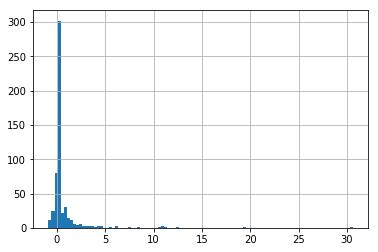

In [12]:
# view results
a = pd.DataFrame([y_pred, y_test]).T
((a[0] - a[1] +1) / (1+a[1])).hist(bins=100)

10.466855524733575

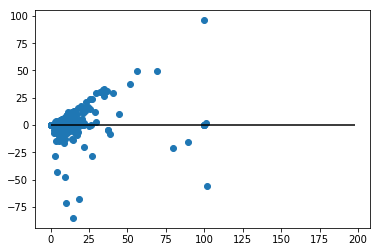

In [13]:
plt.scatter(y_pred, y_pred - y_test)
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
math.sqrt(mean_squared_error(y_test, y_pred))

In [14]:
# determine which features are not relevant
df_features = pd.DataFrame(columns=['name', 'importance'])
df_features['name'] = df.drop('yes_rsvp_count', axis=1).columns
df_features['importance'] = rf.feature_importances_

In [15]:
# least important features
least_important = df_features[df_features['importance'] <= 0.001]['name'].values
df_features[df_features['importance'] <= 0.001]

,name,importance
2,fee.accepts,0.000374
10,rating.average,0.000000
11,rating.count,0.000000
13,venue.city,0.000362
19,waitlist_count,0.000015
27,group_visibility,0.000000


In [16]:
#all features
df_features

,name,importance
0,description,0.139351
1,duration,0.007012
2,fee.accepts,0.000374
3,fee.amount,0.047994
4,fee.required,0.003650
5,group_id,0.037114
6,group.name,0.015030
7,group.who,0.001830
8,how_to_find_us,0.003018
9,event_name,0.052262


In [17]:
# create new df with less relevant feetures removed
df_short = df_final2.drop(least_important, axis=1)
#change certain features to numeric using the length of text from original df
lengths = ['event_name', 'venue.name']
for length in lengths:
    df_short[length] = df_final[length].str.len()
    

In [18]:
df_short['event_name'].fillna(0, inplace=True)
df_short['description'].fillna(0, inplace=True)

In [19]:
df_short

,description,duration,fee.amount,fee.required,group_id,group.name,group.who,how_to_find_us,event_name,event_time,...,normalised_rating,category.name,group_description,members,organizer_picture_rating,event_time_of_the_day,day_of_the_week,month,sin_hour,cos_hour
0,827.0,20700,0.0,0,5817262,257,7,143.0,69.0,74,...,1.50,1,491,917,4.67,10,0,10,0.608761,0.793353
1,2006.0,77400,0.0,0,1627081,128,7,1.0,59.0,41,...,3.33,1,693,1977,4.60,15,5,10,0.866025,0.500000
2,2110.0,37800,0.0,0,1627081,128,7,1.0,39.0,28,...,0.00,1,693,1977,4.60,12,4,10,0.707107,0.707107
3,2006.0,113400,0.0,0,5817262,257,7,1.0,19.0,41,...,3.81,1,491,917,4.67,15,5,10,0.866025,0.500000
4,1829.0,36000,0.0,0,1627081,128,7,1.0,75.0,1007,...,2.00,1,693,1977,4.60,4,4,1,0.258819,0.965926
5,1831.0,36000,0.0,0,5817262,257,7,1.0,75.0,1007,...,3.50,1,491,917,4.67,4,4,1,0.258819,0.965926
6,2111.0,37800,0.0,0,5817262,257,7,1.0,44.0,28,...,0.00,1,491,917,4.67,12,4,10,0.707107,0.707107
7,1874.0,34200,0.0,0,1627081,128,7,1.0,35.0,11,...,0.00,1,693,1977,4.60,15,3,10,0.866025,0.500000
8,793.0,10800,10.0,1,1415286,295,13,1.0,35.0,267,...,4.58,1,1001,874,4.86,30,1,11,-0.866025,-0.500000
9,424.0,5400,0.0,0,19270969,336,7,61.0,27.0,538,...,0.00,0,506,164,5.00,8,4,12,0.500000,0.866025


In [20]:
#adding some new features - results from last 5 events from th group hosting the meetup
groupby_groupid = df_short.groupby('group_id').count()
groupby_groupid = groupby_groupid[groupby_groupid.columns[0]]
groups_at_least5 = groupby_groupid[groupby_groupid > 5].reset_index()['group_id'].tolist()
df_short = df_short.sort_values(['group_id', 'event_time'])
df_short = df_short[df_short['group_id'].isin(groups_at_least5)].reset_index()


In [21]:
df_short = df_short.drop('index', axis=1)

In [22]:
df_short

,description,duration,fee.amount,fee.required,group_id,group.name,group.who,how_to_find_us,event_name,event_time,...,normalised_rating,category.name,group_description,members,organizer_picture_rating,event_time_of_the_day,day_of_the_week,month,sin_hour,cos_hour
0,1313.0,14400,0.0,0,54691,249,24,108.0,74.0,128,...,0.00,1,2127,1426,4.33,24,4,11,-0.500000,-0.866025
1,310.0,10800,0.0,0,54691,249,24,1.0,56.0,415,...,1.50,1,2127,1426,4.33,54,0,11,-0.258819,0.965926
2,310.0,10800,0.0,0,54691,249,24,1.0,56.0,705,...,1.50,1,2127,1426,4.33,54,0,12,-0.258819,0.965926
3,310.0,10800,0.0,0,54691,249,24,1.0,56.0,968,...,1.50,1,2127,1426,4.33,54,0,1,-0.258819,0.965926
4,310.0,10800,0.0,0,54691,249,24,1.0,56.0,1293,...,1.50,1,2127,1426,4.33,54,0,2,-0.258819,0.965926
5,310.0,10800,0.0,0,54691,249,24,1.0,56.0,1556,...,1.50,1,2127,1426,4.33,51,0,3,-0.500000,0.866025
6,310.0,10800,0.0,0,54691,249,24,1.0,56.0,1814,...,1.50,1,2127,1426,4.33,51,0,4,-0.500000,0.866025
7,310.0,10800,0.0,0,54691,249,24,1.0,56.0,2140,...,1.50,1,2127,1426,4.33,51,0,5,-0.500000,0.866025
8,290.0,10800,0.0,0,54691,249,24,1.0,56.0,2389,...,1.50,1,2127,1426,4.33,51,0,6,-0.500000,0.866025
9,290.0,10800,0.0,0,54691,249,24,1.0,56.0,2643,...,1.50,1,2127,1426,4.33,51,0,7,-0.500000,0.866025


In [23]:
# get rsvp values by group
list_df = []
for grp_id in list(df_short['group_id'].unique()):
    df_by_group = df_short.loc[df_short['group_id'] == grp_id]
    yes_rsvp_by_group_df = df_by_group[['event_time', 'yes_rsvp_count']]
    for i in range(1, 6):
        s = yes_rsvp_by_group_df.shift(periods=i)
        df_by_group['last_' + str(i) + '_event_yes_rsvp_count'] = s['yes_rsvp_count']
    list_df.append(df_by_group)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
list_df = [list_df[i].dropna() for i in range(len(list_df))]

In [25]:
df_short_final = pd.concat(list_df)

In [26]:
df_short_final = df_short_final.reset_index()

In [27]:
# create features from the last 5 rsvp results fro different groups
list_previous_event_features = ['last_1_event_yes_rsvp_count', 
                                'last_2_event_yes_rsvp_count', 
                                'last_3_event_yes_rsvp_count', 
                                'last_4_event_yes_rsvp_count', 
                                'last_5_event_yes_rsvp_count']
df_short_final['last_event_max_reached'] = pd.Series(np.argmax(np.array(df_short_final[list_previous_event_features]), axis=1)) + 1
df_short_final['average_5_last_events'] = pd.Series(np.mean(np.array(df_short_final[list_previous_event_features]), axis=1))

In [28]:
df_short_final = df_short_final.drop('index', axis=1)

In [29]:
df_short_final.yes_rsvp_count.value_counts()
drop_indices = np.random.choice(df_short_final.loc[df_short_final.yes_rsvp_count == 1].index, 3400, replace=False)
df_short_final = df_short_final.drop(drop_indices)

In [30]:
drop_indices = np.random.choice(df_short_final.loc[df_short_final.yes_rsvp_count == 2].index, 400, replace=False)
df_short_final = df_short_final.drop(drop_indices)

In [31]:
df_short_final = df_short_final.append([df_short_final.loc[~df_short_final.yes_rsvp_count.isin([1, 2, 0])]]*4, ignore_index=True)

In [32]:
df_short_final.yes_rsvp_count.value_counts()

1      384
3      340
4      290
20     255
2      191
0       70
100     70
16      50
11      45
6       45
13      40
18      40
21      35
8       30
5       25
9       25
27      20
15      15
17      10
101      5
7        5
12       5
23       5
26       5
28       5
33       5
14       5
Name: yes_rsvp_count, dtype: int64

In [33]:
to_drop = ['yes_rsvp_count', 'event_time', 'event_time_of_the_day',
          'last_1_event_yes_rsvp_count', 'last_2_event_yes_rsvp_count', 'last_3_event_yes_rsvp_count', 
          'last_4_event_yes_rsvp_count', 'last_5_event_yes_rsvp_count']

In [34]:
y = np.array(df_short_final['yes_rsvp_count'])
X = np.array(df_short_final.drop(to_drop, axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)


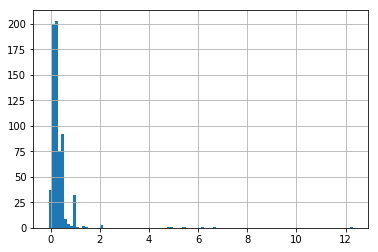

In [35]:
# view results
a = pd.DataFrame([y_pred, y_test]).T
((a[0] - a[1] +1) / (1+a[1])).hist(bins=100)

1.614012850400941

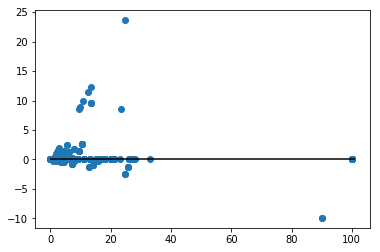

In [36]:
plt.scatter(y_pred, y_pred - y_test)
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
math.sqrt(mean_squared_error(y_test, y_pred))
#lower root MSE than previously

In [37]:
# check how far off predicted values for the test were different from the actual values
abs_score = np.abs(np.round(y_pred) - y_test)
n_0 = len([x for x in abs_score if x == 0])
n_0 / len(abs_score)

0.9205397301349325